In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy

In [3]:
df = pd.read_csv("../data/Training Data_Case 3.csv", index_col=0)
returns = df.pct_change().dropna()
df.tail(252*3).to_dict()

{'A': {1513: 201.77,
  1514: 202.05,
  1515: 206.58,
  1516: 210.42,
  1517: 208.15,
  1518: 213.37,
  1519: 211.22,
  1520: 216.52,
  1521: 223.27,
  1522: 225.75,
  1523: 223.92,
  1524: 219.87,
  1525: 218.64,
  1526: 219.19,
  1527: 213.5,
  1528: 216.92,
  1529: 217.66,
  1530: 223.63,
  1531: 225.24,
  1532: 224.15,
  1533: 214.29,
  1534: 223.95,
  1535: 226.68,
  1536: 225.62,
  1537: 226.04,
  1538: 216.89,
  1539: 216.75,
  1540: 229.45,
  1541: 239.55,
  1542: 229.34,
  1543: 224.82,
  1544: 226.38,
  1545: 224.28,
  1546: 233.56,
  1547: 240.79,
  1548: 249.36,
  1549: 248.47,
  1550: 248.69,
  1551: 248.52,
  1552: 253.97,
  1553: 252.83,
  1554: 252.04,
  1555: 253.7,
  1556: 257.83,
  1557: 261.85,
  1558: 262.17,
  1559: 263.56,
  1560: 263.02,
  1561: 260.32,
  1562: 264.93,
  1563: 272.17,
  1564: 270.51,
  1565: 263.85,
  1566: 261.37,
  1567: 263.91,
  1568: 265.12,
  1569: 263.74,
  1570: 260.94,
  1571: 269.74,
  1572: 265.96,
  1573: 273.41,
  1574: 269.74,
  157

In [64]:
class MaximizeSharpeModel:
    def __init__(self, historical_prices):
        self.historical_prices = historical_prices
        self.num_assets = len(self.historical_prices.columns)
        
        self.returns = np.array(self.historical_prices.pct_change().dropna())
        self.mean_returns = np.mean(self.returns, axis=0)
        self.cov_matrix = np.cov(self.returns.T)
        
        self.skewness = np.array([scipy.stats.skew(ret) for ret in self.returns.T])
        self.kurtosis = np.array([scipy.stats.kurtosis(ret) for ret in self.returns.T])
        
        self.sharpe_ratio = None
        self.weights = self._optimize_weights()
        
    def _negative_sharpe_ratio(self, weights, mean_returns, cov_matrix, skewness, kurtosis):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        a = 1 + skewness @ weights + 0.5 * kurtosis @ np.square(weights)
        sharpe_ratio = (portfolio_return / portfolio_std_dev) * np.power(np.sign(a) * np.abs(a), 1/3)
        return -sharpe_ratio
    
    def _optimize_weights(self):
        # set the initial weight allocation to be equal for all assets
        weights_0 = np.array([1/self.num_assets]*self.num_assets)

        # define the constraints for the optimization
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # define the bounds for the optimization (between 0 and 1 for each weight)
        bounds = tuple((0,1) for _ in range(self.num_assets))

        # minimize the negative Sharpe ratio to find the optimal weights
        result = minimize(self._negative_sharpe_ratio, weights_0, args=(self.mean_returns, self.cov_matrix, self.skewness, self.kurtosis), method='SLSQP', bounds=bounds, constraints=constraints)

        # calculate the Sharpe ratio for the optimal weights
        optimal_weights = result.x
        optimal_return = np.dot(optimal_weights, self.mean_returns)
        optimal_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(self.cov_matrix, optimal_weights)))
        self.sharpe_ratio = np.sqrt(252) * optimal_return / optimal_std_dev
        
        return result.x
    
    def append_prices(self, current_prices):
        # self.historical_prices.loc[-1] = current_prices
        self.historical_prices = pd.concat([self.historical_prices, pd.DataFrame(current_prices, columns=['A','B','C','D','E','F','G','H','I','J'])])
        self.returns = np.array(self.historical_prices.pct_change().dropna())
    
    def update_weights(self):
        self.mean_returns = np.mean(self.returns, axis=0)
        self.cov_matrix = np.cov(self.returns.T)
        
        self.skewness = np.array([scipy.stats.skew(ret) for ret in self.returns.T])
        self.kurtosis = np.array([scipy.stats.kurtosis(ret) for ret in self.returns.T])
        self.weights = self._optimize_weights()
        
        

In [69]:
start = 252*3

model = MaximizeSharpeModel(df[:start])

sharpe_ratios = []
for i in range(start,len(df)):
    model.append_prices(df[i:i+1])
    # if i % 200 == 0:
    model.update_weights()
    sharpe_ratios.append(model.sharpe_ratio)


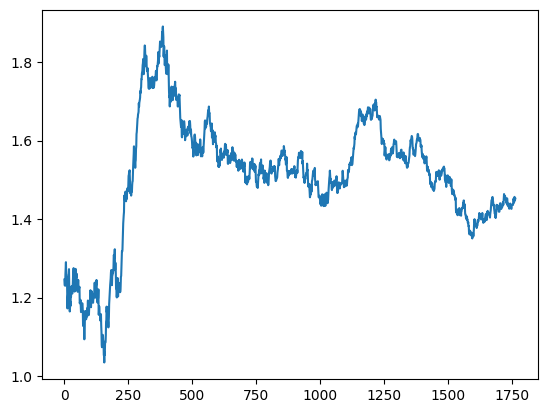

In [70]:
plt.plot(sharpe_ratios)

In [71]:
print(model.sharpe_ratio)

1.452313934818539
